In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from math import sqrt
from sklearn import metrics

# Reading the data :

In [3]:
cc_df=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

In [4]:
cc_df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
cc_df.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [7]:
# no null values in the data set

# Visualizing the data:

<AxesSubplot:>

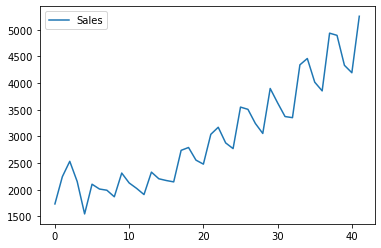

In [8]:
# line plot

cc_df.plot()

Sales plot has a  linear Trend and multiplicative seasonility

In [9]:
cc_df["Quaters"]=0
cc_df['Year']=0

In [10]:
# creating a quarterly column and yearly column:

for i in range(0,42):
    q=str(cc_df.iloc[i,0])
    x=q.split("_")
    #print('q: ',q)
    #print('x : ',x)
    cc_df["Quaters"][i]=x[0]
    cc_df["Year"][i]=x[1]


In [11]:
cc_df.head()

,Quarter,Sales,Quaters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


<AxesSubplot:xlabel='Year', ylabel='Quaters'>

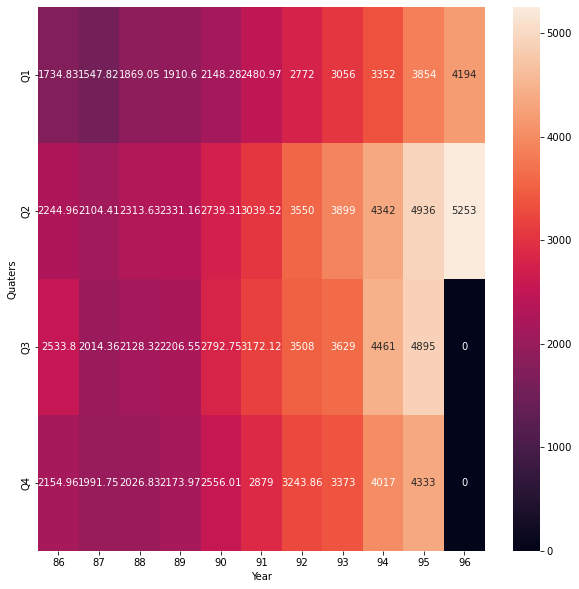

In [12]:
# Heat map

plt.figure(figsize=(10,10))
heatmap_al=pd.pivot_table(data=cc_df,values='Sales',index='Quaters',columns='Year',aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_al,annot=True,fmt="g") #fmt is format of the grid values

# Data Preprocessing :

In [13]:
# creating dummy variables for quarterly  to see how different quarters effect the output i.e., no of sales

cc_df=pd.get_dummies(data=cc_df , columns=['Quaters'])

In [14]:
cc_df.head()

,Quarter,Sales,Year,Quaters_Q1,Quaters_Q2,Quaters_Q3,Quaters_Q4
0,Q1_86,1734.827000,86,1,0,0,0
1,Q2_86,2244.960999,86,0,1,0,0
2,Q3_86,2533.804993,86,0,0,1,0
3,Q4_86,2154.962997,86,0,0,0,1
4,Q1_87,1547.818996,87,1,0,0,0


In [15]:
# Creating the transformations:

cc_df['t']=np.arange(1,43)  # t

cc_df['t_squared']=cc_df['t']*cc_df['t']   # t^2

cc_df['log_sales']=np.log(cc_df['Sales'])   # log transform

In [16]:
cc_df.head()

,Quarter,Sales,Year,Quaters_Q1,Quaters_Q2,Quaters_Q3,Quaters_Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,87,1,0,0,0,5,25,7.344602


Train Test Splitting :

In [17]:
train=cc_df.head(40)
test=cc_df.tail(2)

In [18]:
train.tail()

,Quarter,Sales,Year,Quaters_Q1,Quaters_Q2,Quaters_Q3,Quaters_Q4,t,t_squared,log_sales
35,Q4_94,4017.0,94,0,0,0,1,36,1296,8.298291
36,Q1_95,3854.0,95,1,0,0,0,37,1369,8.256867
37,Q2_95,4936.0,95,0,1,0,0,38,1444,8.504311
38,Q3_95,4895.0,95,0,0,1,0,39,1521,8.495970
39,Q4_95,4333.0,95,0,0,0,1,40,1600,8.374015


# Model Driven Forecasting :

In [19]:
# Linear model


linear_model=smf.ols('Sales ~ t',data=train).fit()
pred_linear=linear_model.predict(test['t'])
rmse_linear=sqrt(metrics.mean_squared_error(test['Sales'],pred_linear))
rmse_linear

589.8085648896489

In [20]:
# Exponential model

exp_model=smf.ols('log_sales ~ t' , data = train).fit()
pred_exp = exp_model.predict(test['t'])
rmse_exp=sqrt(metrics.mean_squared_error(test['Sales'] , np.exp(pred_exp)))
rmse_exp

487.1548789146992

In [21]:
# Quadratic 

quad_model=smf.ols('Sales~t+t_squared' , data = train).fit()
pred_quad = quad_model.predict(test[['t','t_squared']])
rmse_quad=sqrt(metrics.mean_squared_error(test['Sales'] , pred_quad))
rmse_quad

522.7788029934632

In [22]:
# Additive Seasonility 

add_sea_model=smf.ols('Sales~Quaters_Q1+Quaters_Q2+Quaters_Q3+Quaters_Q4',data=train).fit()
pred_add_sea=add_sea_model.predict(test[['Quaters_Q1','Quaters_Q2','Quaters_Q3','Quaters_Q4']])
rmse_add_sea=sqrt(metrics.mean_squared_error(test['Sales'] , pred_add_sea))
rmse_add_sea


1921.7154825796265

In [23]:
# Additive seasonality Quadratic Trend

add_sea_quad_model=smf.ols('Sales~t+t_squared+Quaters_Q1+Quaters_Q2+Quaters_Q3+Quaters_Q4',data=train).fit()
pred_add_sea_quad=add_sea_quad_model.predict(test[['t','t_squared','Quaters_Q1','Quaters_Q2','Quaters_Q3','Quaters_Q4']])
rmse_add_sea_quad=sqrt(metrics.mean_squared_error(test['Sales'] , pred_add_sea_quad))
rmse_add_sea_quad

272.5062062646674

In [24]:
# Multiplicative seasonality

mult_sea_model=smf.ols('log_sales~Quaters_Q1+Quaters_Q2+Quaters_Q3+Quaters_Q4',data=train).fit()
pred_mult_sea=mult_sea_model.predict(test[['Quaters_Q1','Quaters_Q2','Quaters_Q3','Quaters_Q4']])
rmse_mult_sea=sqrt(metrics.mean_squared_error(test['Sales'] , np.exp(pred_mult_sea)))
rmse_mult_sea

2039.1886019046492

In [25]:
#Multiplicative Seasonality with Linear trend

mult_add_sea_model=smf.ols('log_sales~t+Quaters_Q1+Quaters_Q2+Quaters_Q3+Quaters_Q4',data=train).fit()
pred_mult_add_sea=mult_add_sea_model.predict(test[['t','Quaters_Q1','Quaters_Q2','Quaters_Q3','Quaters_Q4']])
rmse_mult_add_sea=sqrt(metrics.mean_squared_error(test['Sales'] , np.exp(pred_mult_add_sea)))
rmse_mult_add_sea

162.37135848192275

In [26]:
# Comparing the rmse of all models

rmse={'Models' :['linear_model','exp_model','quad_model','add_sea_model','add_sea_quad_model','mult_sea_model','mult_add_sea_model'],
       'rmse values ':[rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea]}
rmse_df=pd.DataFrame(rmse)
rmse_df

,Models,rmse values
0,linear_model,589.808565
1,exp_model,487.154879
2,quad_model,522.778803
3,add_sea_model,1921.715483
4,add_sea_quad_model,272.506206
5,mult_sea_model,2039.188602
6,mult_add_sea_model,162.371358


Conclusion : On comparing the rmse of each models , Multiplicative seasonality with linear has got the least error.
So, that is the best model for prediction.

# Final model :

In [27]:
final_model=smf.ols('log_sales~ t+Quaters_Q1+Quaters_Q2+Quaters_Q3+Quaters_Q4',data=cc_df).fit()
cc_df['pred_sales']=np.exp(final_model.predict(cc_df[['t','Quaters_Q1','Quaters_Q2','Quaters_Q3','Quaters_Q4']]))

In [28]:
cc_df.head()

,Quarter,Sales,Year,Quaters_Q1,Quaters_Q2,Quaters_Q3,Quaters_Q4,t,t_squared,log_sales,pred_sales
0,Q1_86,1734.827000,86,1,0,0,0,1,1,7.458663,1539.516800
1,Q2_86,2244.960999,86,0,1,0,0,2,4,7.716443,1958.133190
2,Q3_86,2533.804993,86,0,0,1,0,3,9,7.837477,1941.716476
3,Q4_86,2154.962997,86,0,0,0,1,4,16,7.675529,1792.297460
4,Q1_87,1547.818996,87,1,0,0,0,5,25,7.344602,1695.770302


<AxesSubplot:>

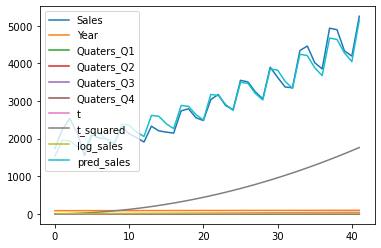

In [29]:
cc_df.plot()

Actual sales and predicted sales are following almost the same trend and seasonality